In [1]:
import sys
import os
# Dynamically get the path of the current directory
current_dir = os.getcwd()

# Assuming the package is one level up
local_package_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add this path to sys.path
sys.path.insert(0, local_package_dir)

# Now you can import your local package
from util import validate
import pandas as pd
from truthnet import load_veritas_model
import numpy as np
from tqdm import tqdm
import numpy as np
import pylab as plt
import seaborn as sns

In [2]:
resf1=pd.read_csv('../../data/res_exp2_model2_screened.csv',index_col=0).T
resf1.columns=['lower_threshold','veritas','score']
d1,wf1=validate(resf1.copy(),C0=1,C1=0.76,C2=1.35,DX=False,score=True,
         outfile='exptvalid.png',plots=False,
         validation_type='fnrexpt')

In [3]:
resf=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
resf['dx'] = [int(x[-1]) for x in resf.index.values]
d2,wf2,zt=validate(resf.copy(),C0=1,C1=0.76,C2=1.35,DX=True,score=True,verbose=False,
         outfile='ptsdvalid.png',plots=False,
         validation_type='withdx')

In [4]:
M=load_veritas_model('../../veritas_models/veritas_002.pkl.gz')

In [5]:
lf=M['calibration_lower']
xmin,xmax=1,1.4
ld=M['dist_lower']

In [6]:
vf=M['calibration_veritas']
vd=M['dist_veritas']
xmind,xmaxd=vf.min(),vf.max()

In [7]:
wf1.columns=[r'$\kappa$',r'$\nu$',r'$\mu$','DX',r'$\chi$']
wf2.columns=[r'$\kappa$',r'$\nu$',r'$\mu$','DX',r'$\chi$']
# note dx for wf1 (expt) is estimated

In [8]:
R={}
for c0 in tqdm(np.arange(.8,1.1,.05)):
    for c2 in np.arange(1,1.5,.05):
        b,_,_=validate(resf,C0=c0,C1=0.76,C2=c2,DX=True,
                   score=True,plots=False,verbose=False,
                   validation_type='withdx')
    
        a,_=validate(resf1,C0=c0,C1=0.76,C2=1.35,DX=False,score=True,plots=False,
                   validation_type='fnrexpt')

        R[(c0,c2)]=(1-a['fnr'],1-b['mratio'],1 - 0.5*(a['fnr'] + b['mratio']+a['fnr']*b['mratio'] ))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:01<00:00, 25.92s/it]


In [9]:
rf=pd.DataFrame(R).T
rf.columns=['sensitivity','maxspecificity','minauc']
rf.index.name='thresholds'
rff=rf[['sensitivity','maxspecificity']].reset_index()
rff=rff.rename(columns={'sensitivity':'tpr'})
rff['fpr']=1-rff.maxspecificity
rff=rff.drop('maxspecificity',axis=1)
rff.to_csv('perf.csv')

from zedstat import zedstat
ztm=zedstat.processRoc(df=rff,
                      order=3, 
                      total_samples=304+310,
                      positive_samples=310,
                      alpha=0.01,
                      prevalence=0.31)
ztm.smooth(STEP=0.001)
ztm.allmeasures(interpolate=False)
ztm.usample(precision=3)
ztm.auc()

(0.9489749999999999, 0.9673042347824764, 0.9306485832142335)

In [10]:
#rf.reset_index().to_csv('minaucres.csv',index=None)

In [11]:
rf.index.name=('C0','C2')
rf_=rf.reset_index()
rf_.columns=['C0', 'C2', 'sensitivity', 'maxspecificity', 'minauc']

In [12]:
rf_[(rf_.C0.between(.95,1.1)) & (rf_.C2.between(1.3,1.4))]

,C0,C2,sensitivity,maxspecificity,minauc
36,0.95,1.30,0.91,0.825581,0.859942
37,0.95,1.35,0.91,0.837209,0.866279
46,1.00,1.30,0.94,0.779070,0.852907
47,1.00,1.35,0.94,0.790698,0.859070
56,1.05,1.30,0.97,0.662791,0.811337
57,1.05,1.35,0.97,0.674419,0.817326


In [13]:
rf_[(rf_.sensitivity>.88) & (rf_.maxspecificity>.89)]

,C0,C2,sensitivity,maxspecificity,minauc
28,0.9,1.40,0.89,0.906977,0.893372
29,0.9,1.45,0.89,0.906977,0.893372


In [14]:
ztm.getBounds()
ZX=ztm.get().dropna()
II=np.append(ZX[ZX.tpr>.9].head(1).index.values,ZX[ZX.ppv>.86].head(1).index.values)

In [15]:
ZZ=ztm.get().join(ztm.usample(ztm.df_lim['U']),rsuffix='U').join(ztm.usample(ztm.df_lim['L']),lsuffix='L').dropna()
ZL=ZZ[['tprL', 'ppvL', 'accL', 'npvL', 'LR+L', 'LR-L']]
Z0=ZZ[['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']]
ZU=ZZ[['tprU', 'ppvU', 'accU', 'npvU', 'LR+U', 'LR-U']]
ZU.columns=['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']
ZL.columns=['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']
from zedstat.textable import tablewithbounds
xf=tablewithbounds(Z0,ZU,ZL)#.to_csv('table.csv')
xf=xf.loc[II]
xf.index=1-xf.index
xf.index.name='specificity'
xf=xf.rename(columns={'tpr':'sensitivity','acc':'accuracy'})
from zedstat.textable import textable
textable(xf,tabname='../tex/Figures/tabperf.tex',FORMAT='%1.2f',
         INDEX=True,LNTERM='\\\\\n',TABFORMAT='L{.69in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}')     

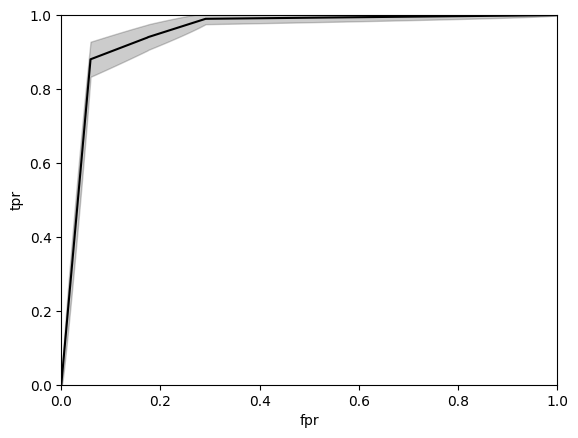

In [16]:
ax=plt.gca()
ax=ztm.get().tpr.plot(ax=ax,color='k')
plt.fill_between(x=ztm.get().index, y1=ztm.df_lim['U'].tpr,y2=ztm.df_lim['L'].tpr, color='k',alpha=.2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_ylabel('tpr');

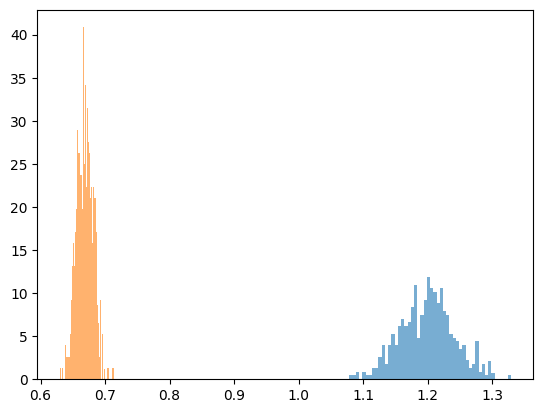

In [17]:
lh=plt.hist(lf, bins=50, density=True, alpha=0.6)
vh=plt.hist(vf, bins=50, density=True, alpha=0.6)


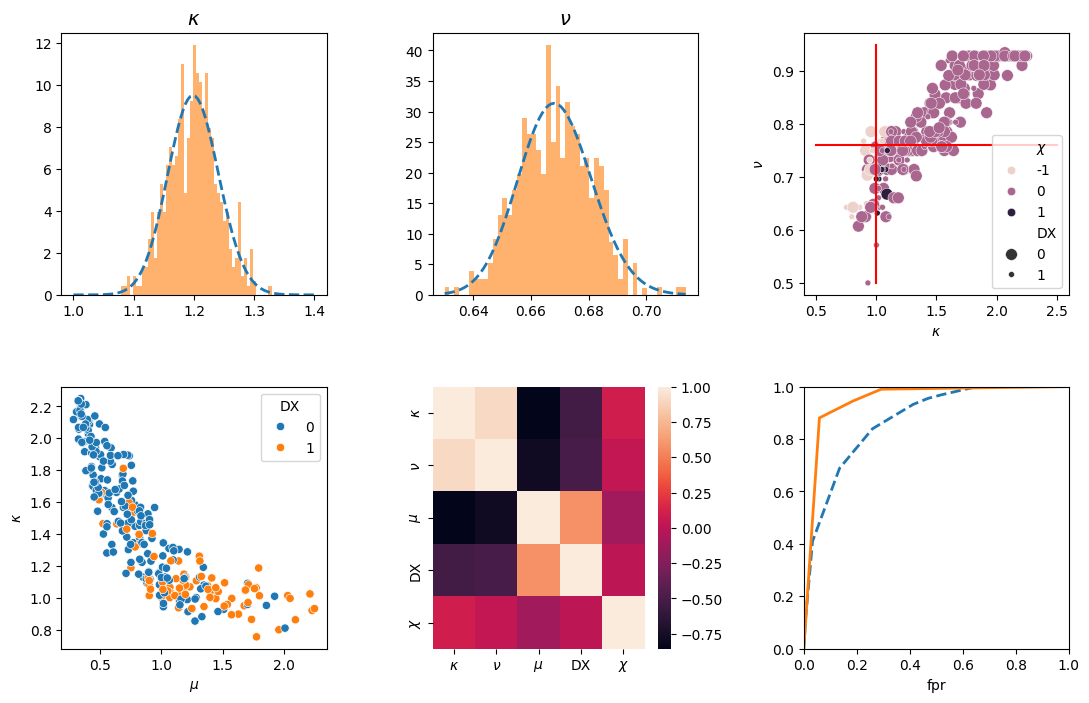

In [19]:
#from jupyterthemes import jtplot
#jtplot.style()


#plt.style.use('seaborn-talk')

plt.figure(figsize=[13,8])
plt.subplots_adjust(wspace=0.4, hspace=0.35)

# First subplot
plt.subplot(231)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, ld.pdf(x), '--',lw=2)
plt.hist(lf, bins=50, density=True, alpha=0.6)
#plt.xlabel('X-axis label', fontsize=12)  # Set font size for x-label
#plt.ylabel('Y-axis label', fontsize=12)  # Set font size for y-label
plt.title('$\kappa$', fontsize=14)    # Set font size for title

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Second subplot
plt.subplot(232)
xd = np.linspace(xmind, xmaxd, 100)
plt.plot(xd, vd.pdf(xd), '--',lw=2)
plt.hist(vf, bins=50, density=True, alpha=0.6)
plt.title(r"$\nu$", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

# First subplot
plt.subplot(233)
C0=1
C1=0.76
C2=1.25
#ax=sns.scatterplot(data=response_dataframe,x='score',y='veritas',hue='dx')
#plt.plot([.2,2.5],[C1,C1],'-r')
#plt.plot([C2,C2],[.5,.95],'-r')
sns.scatterplot(data=wf2,x=r'$\kappa$',y=r'$\nu$',hue=r'$\chi$',size='DX')
plt.plot([.5,2.5],[.76,.76],'-r')
plt.plot([C0,C0],[.5,.95],'-r')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);



# First subplot
plt.subplot(234)
sns.scatterplot(data=wf2,x=r'$\mu$',y=r'$\kappa$',hue='DX')
#plt.plot([.2,2.5],[C0,C0],'-r')
#plt.plot([C2,C2],[.5,2],'-r')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);


# First subplot
plt.subplot(235)
sns.heatmap(wf2.corr())


# First subplot
plt.subplot(236)
zt.get().tpr.plot(lw=2,style='--')
ztm.get().tpr.plot(lw=2)
plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

plt.savefig('fig2.pdf',dpi=600,bbox_inches='tight',transparent=True)

In [20]:
pd.DataFrame(ld.pdf(x),x,columns=['kappa']).reset_index().rename(columns={'index':'x'}).to_csv('kappa.csv',index=None)
pd.DataFrame(vd.pdf(xd),xd,columns=['nu']).reset_index().rename(columns={'index':'xd'}).to_csv('nu.csv',index=None)
pd.DataFrame(ztm.get()['tpr']).join(pd.DataFrame(ztm.df_lim['U']['tpr']),
                                    rsuffix='U').join(pd.DataFrame(ztm.df_lim['L']['tpr']),rsuffix='L').to_csv('vroc.csv')
pd.DataFrame(zt.get()['tpr']).join(pd.DataFrame(zt.df_lim['U']['tpr']),
                                    rsuffix='U').join(pd.DataFrame(zt.df_lim['L']['tpr']),rsuffix='L').to_csv('roc.csv')
wf2.to_csv('vadata_res.csv')
wf1.to_csv('expdata_res.csv')
wf1.corr().to_csv('expcorr.csv')
wf2.corr().to_csv('vacorr.csv')
lh_=pd.DataFrame(lh[0],lh[1][0]+np.diff(lh[1]).cumsum()).reset_index()
vh_=pd.DataFrame(vh[0],vh[1][0]+np.diff(vh[1]).cumsum()).reset_index()
lh_.columns=['x','kappa']
vh_.columns=['x','mu']
lh_.to_csv('kappa_h.csv',index=None)
vh_.to_csv('nu_h.csv',index=None)


In [25]:
mupos=wf2[wf2.DX==1]['$\mu$']
muneg=wf2[wf2.DX==0]['$\mu$']


<Axes: xlabel='$\\mu$', ylabel='Density'>

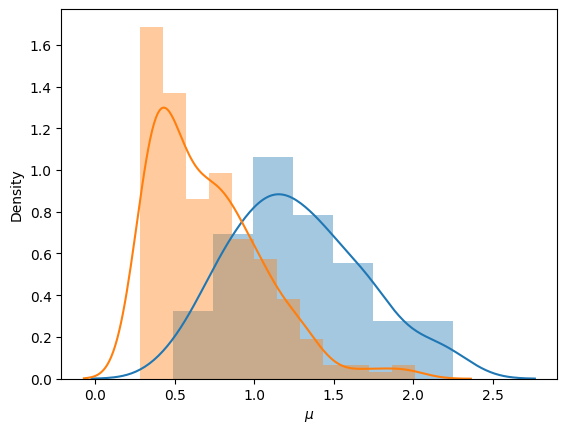

In [30]:
sns.distplot(mupos)
sns.distplot(muneg)


In [33]:
M['model'].shap_index

array([180,  29,  94,  79, 171,  87, 139, 173,  80, 201, 169,  71, 149,
       135, 170,  78, 205, 148, 179, 168,  84, 138,  49,  90, 187, 131,
        20, 185, 157,   7, 114, 182,  22,  26,   4, 175, 102,  92,  17,
       124, 127,  39,  59,  95, 141,  73, 108,  86,  57,  42,  16, 113,
       192, 105, 207,  77,  97, 152, 154,  31,   5,  88, 136, 134, 183,
       155,  46,  58, 172, 130, 164,  69, 186,  19,  52, 112,  38,  65,
        10, 140, 156,  45,  89, 208,  63, 122,  28, 103,  62, 203,  24,
        47,   9,   6, 117, 206,  36, 125,  61,  48,  14,  70,  55,  12,
       142, 145,  53,  21,  25,  33, 111, 146,  85, 126, 128, 189, 161,
       104,  44,  82,  74, 177, 184, 150, 181, 107,  91, 137,  76,  75,
       160, 166, 132, 163,  50, 143,  23, 196, 174,   8, 118, 165,  51,
       204, 178,  64,  41,  67,   1, 176,  54, 109,  37, 121, 151,   2,
       197,  83, 202, 190, 200, 188,  40, 199,  56,  72, 133, 193,  99,
        13, 195,  35, 116,  27, 101, 167,  43, 147,  96, 119,  9